# <center> Prédiction de la position des objets connectés -- Projet IOT


<img src="https://raw.githubusercontent.com/kasamoh/IoT/master/img/ADS-Background-img.jpg">



Les objets connectés envoient à des intervalles de temps réguliers des messages qui transitent par le réseau GSM. Des antennes appelées stations de base reçoivent ces messages et sont chargées de les transmettre via un réseau filaire. Notre objectif est d'implémenter un algorithme d'apprentissage automatique pour prédire la position d'un objet à partir des messages réceptionnés par les stations de base.
Pour ce faire ,on commencera par une analyse descriptive et graphique des données,ensuite,on testera les approches suivantes : 

- Une approche RSSI / Distance avec ajout de la densité urbaine puis régression XGBOOST 
- Metric Learning  & KNN ajusté
- KNN adaptatifs

### Plan : 
1. Chargement & Exploration des données 
2. XGboost avec densité urbaine
3. Metric Learning
4. KNN ajusté
5. Prédiction sur le test



## Import des packages 

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import gaussian_kde
from geopy.distance import vincenty,distance
import time

from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import pairwise_distances

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
import numpy
import itertools as it

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors.ball_tree import BallTree
import math
from sklearn.cluster import DBSCAN
from matplotlib.pyplot import figure

#Cartographie
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from cartopy.io.img_tiles import OSM

import scipy 
import seaborn as sns
import geopy.distance


from xgboost import XGBRegressor

sns.set(color_codes=True)
%matplotlib inline

## 1. Chargement & Exploration des données 


L'extraction des données se fait simplement sous Python via la librairie pandas. On dispose de 3 jeux de données. Deux jeux de données pour le train composés des différentes données géographique de base et de reception d'un message suivant une puissance définie et un jeu de test.

On se focalisera sur les variables suivantes du Mess_train :

 * Messid : L'identifiant du message
 * RSSI : Le RSSI en dBm  ( une mesure de puissance du message réçu )
 * bsid : L'identifiant de la station
 * did :  L'identifiant du device
 * bs_lat : La latitude de la station ayant reçu le message 
 * bs_long : La longitude de la station ayant reçu le message 


In [3]:
######################################## Chargement du train  & test & pos ####################################

#### identifiant de la colonne
colmessage='messid' 

# load  label , train and test data
pos_train =pd.read_csv("pos_train_list.csv")
df_mess_train = pd.read_csv("mess_train_list.csv")
df_mess_test = pd.read_csv("mess_test_list.csv")

df_mess_train.head()


messid  bsid       did  nseq   rssi       time_ux  \
0  573bf1d9864fce1a9af8c5c9  2841  473335.0   0.5 -121.5  1.463546e+12   
1  573bf1d9864fce1a9af8c5c9  3526  473335.0   2.0 -125.0  1.463546e+12   
2  573bf3533e952e19126b256a  2605  473335.0   1.0 -134.0  1.463547e+12   
3  573c0cd0f0fe6e735a699b93  2610  473953.0   2.0 -132.0  1.463553e+12   
4  573c0cd0f0fe6e735a699b93  3574  473953.0   1.0 -120.0  1.463553e+12   

      bs_lat      bs_lng  
0  39.617794 -104.954917  
1  39.677251 -104.952721  
2  39.612745 -105.008827  
3  39.797969 -105.073460  
4  39.723151 -104.956216

## Exploration des données 

Avant de nous lancer dans le traitement des données nous décidons de mieux les comprendre en utilisant des tableaux et des plots descriptifs.

#### 1-Listes des stations  (BS)

In [45]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

print( "Le nombre de stations est %s" %listOfBs.size )

Le nombre de stations est 259


#### 2-RSSi

In [4]:
df_mess_train.describe()


bsid           did          nseq          rssi       time_ux  \
count  39250.000000  3.925000e+04  39250.000000  39250.000000  3.925000e+04   
mean    4533.774752  4.835932e+05      1.043541   -125.863580  1.473368e+12   
std     2570.495638  9.893140e+04      0.563540      9.226500  5.506910e+09   
min      879.000000  4.732880e+05      0.000000   -155.000000  1.463546e+12   
25%     2790.000000  4.761230e+05      1.000000   -132.500000  1.468410e+12   
50%     3559.000000  4.763150e+05      1.000000   -127.333333  1.473444e+12   
75%     7456.000000  4.766090e+05      1.500000   -121.000000  1.479118e+12   
max    11951.000000  1.747448e+06      2.000000    -64.000000  1.481143e+12   

             bs_lat        bs_lng  
count  39250.000000  39250.000000  
mean      42.554998   -100.969685  
std        7.722787     11.522732  
min       36.053394   -107.463146  
25%       39.747448   -105.074287  
50%       39.793585   -105.043685  
75%       39.838740   -104.998429  
max       64.300000    -68.500000

/home/user/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:3358: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


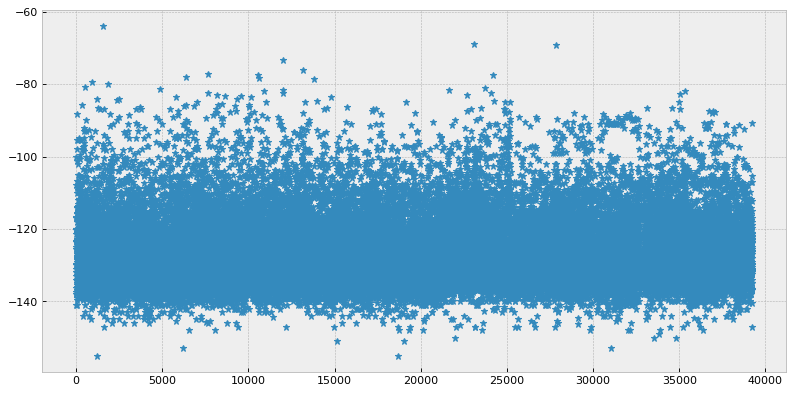

In [31]:
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')


# use the function regplot to make a scatterplot
df=pd.DataFrame({'x': range(0,df_mess_train.shape[0]), 'y': df_mess_train["rssi"] })
plt.style.use('bmh')

# plot
plt.plot( 'x', 'y', data=df, linestyle='none', marker='*')
plt.show()


/data/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


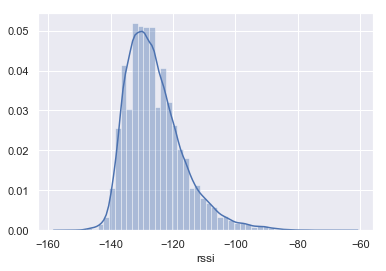

In [4]:
sns.distplot(df_mess_train['rssi'])

On se rend compte que la majorité des valeurs de puissance en réception sont comprises entre -140 et -100 et que l'on compte quelques valeurs extrêmes pas nécessairement aberrantes.


#### 3- Stations ( BS )

Notre problèmatique étant tournée vers des données géographiques, essayons réprésenter en deux dimensions les données de latitude et de longitude des stations sur notre jeu d'entrainement.


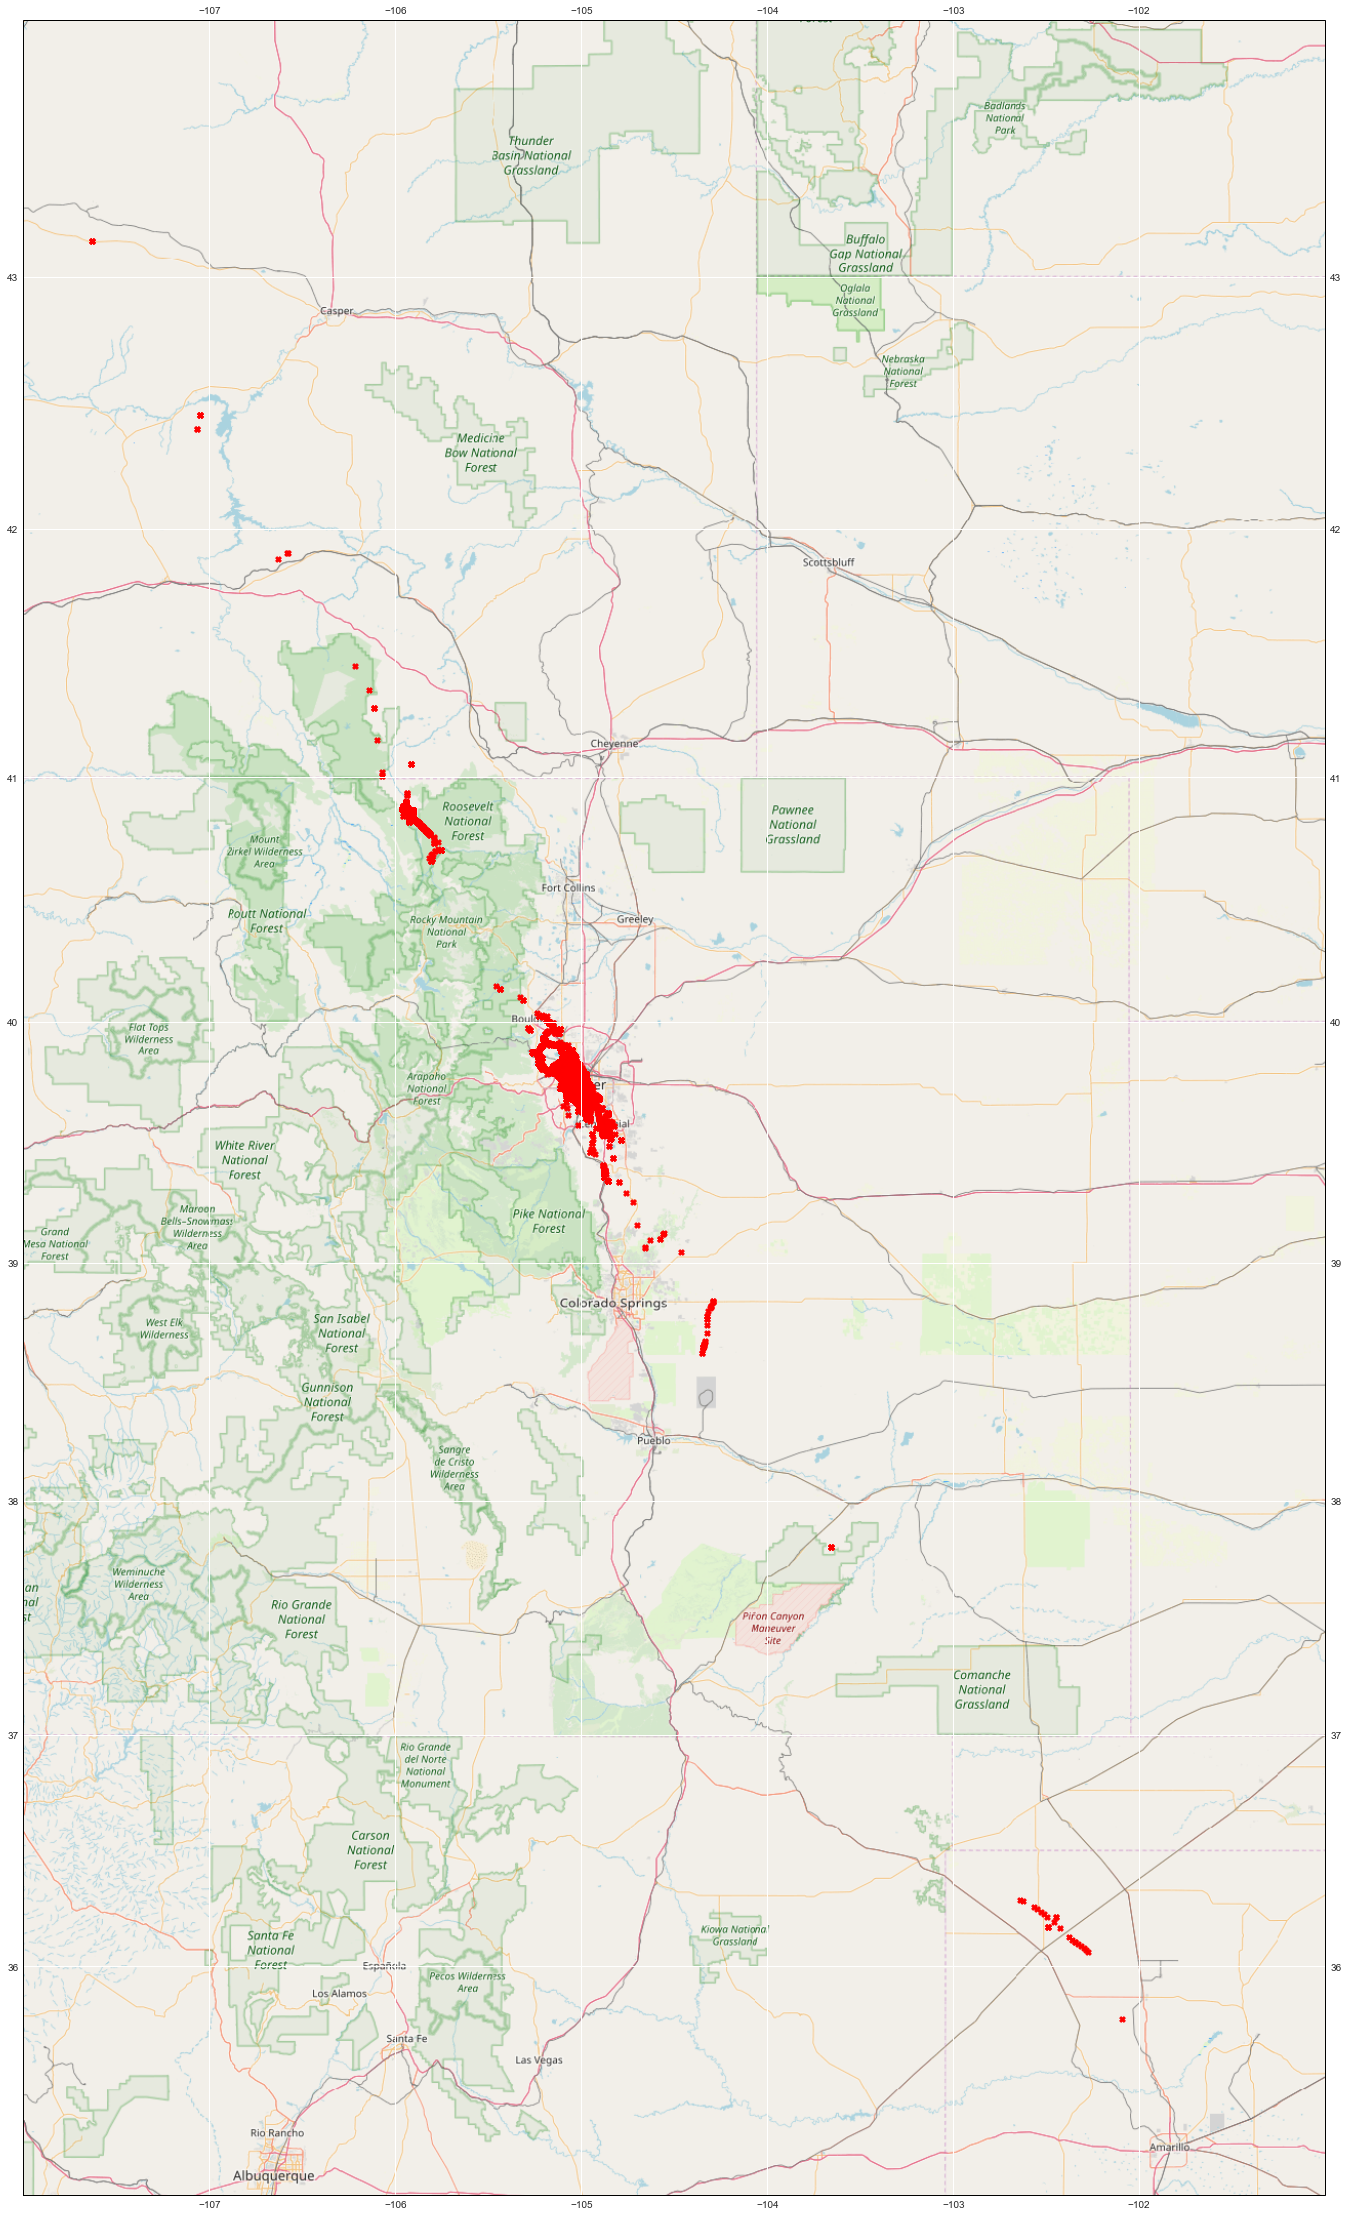

In [7]:
# Carto
fig = plt.figure(figsize=(50, 40))
osm_tiles = OSM()
ax = plt.axes(projection=osm_tiles.crs)

ax.set_extent([-108, -101, 35, 44])
ax.add_image(osm_tiles, 8,interpolation='bilinear')
ax.scatter('lng','lat',transform = ccrs.PlateCarree(),data=pos_train,s=30,marker='X',color='red')
ax.gridlines(draw_labels=True)

Essayons de repérer les stations qui ont des positions très loins de la majorité avec la méthode de clusetring DBSCAN : 

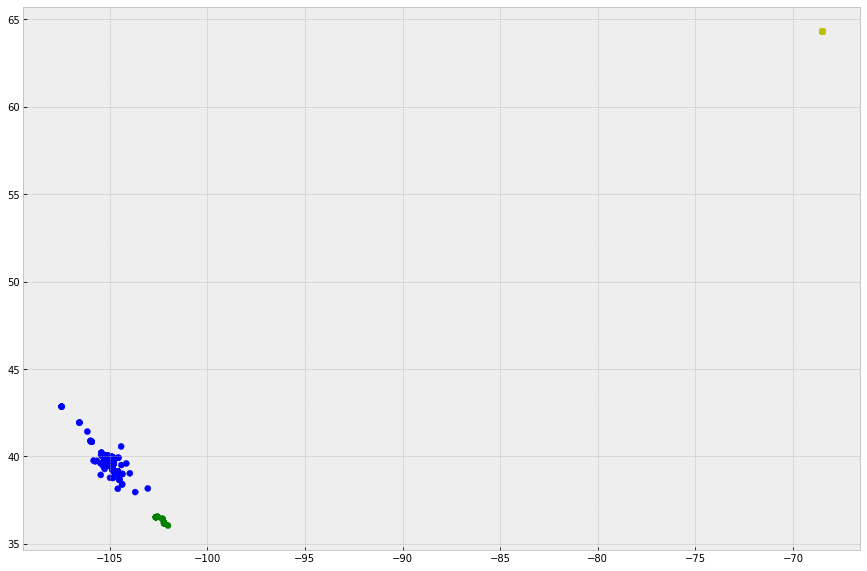

In [32]:
################################ Clustering pour detecter les outliers ######################################

model = DBSCAN(eps=1.5, min_samples=5)
df_outliers_messtrain=df_mess_train[1:35000] # on tourne sur 99% des stations 
y = model.fit_predict(df_outliers_messtrain[['bs_lng', 'bs_lat']])

def convert_color(y):
    if y==0:
        return 'b'
    elif y==1:
        return 'y'
    elif y==2:
        return 'g'
    else:
        return 'r'
    
y_color = list(map(lambda x: convert_color(x), y))
plt.figure(figsize=(15,10))
plt.scatter(df_outliers_messtrain['bs_lng'], df_outliers_messtrain['bs_lat'], c=y_color)
plt.show()


In [39]:
bsid_weird = np.unique(df_outliers_messtrain['bsid'][y == 1])
bsid_weird

array([ 1594,  1661,  2293,  4129,  4156,  4959,  4993,  8355,  8449,
        8451,  8560, 10151, 10162, 10999, 11007])

Ces stations ont des positions assez éloignées des autres ( outliers ) , on ne peut pas les supprimer car on a ce comportement sur le jeux de données test

#### 4 - Jeux de données test

In [5]:
df_mess_test.describe()


bsid           did          nseq          rssi       time_ux  \
count  29286.000000   29286.00000  29286.000000  29286.000000  2.928600e+04   
mean    4643.290651  411306.93263      1.043075   -125.742454  1.472354e+12   
std     2578.625841  134472.75089      0.611285      8.861454  5.101975e+09   
min     1012.000000  110335.00000      0.000000   -151.000000  1.463542e+12   
25%     2846.000000  472397.00000      1.000000   -132.000000  1.468001e+12   
50%     3563.000000  472504.00000      1.000000   -127.000000  1.472920e+12   
75%     7456.000000  472533.00000      1.500000   -121.000000  1.476688e+12   
max    11007.000000  473287.00000      2.000000    -63.000000  1.481142e+12   

             bs_lat        bs_lng  
count  29286.000000  29286.000000  
mean      42.332918   -101.228888  
std        7.517469     11.198741  
min       36.528704   -110.957181  
25%       39.734330   -105.077530  
50%       39.777690   -105.045347  
75%       39.807916   -105.008827  
max       64.300000    -68.500000

#### 5 - Positions réelles des messages sur le train 

In [34]:
pos_train.head()


lat         lng
0  39.606690 -104.958490
1  39.606690 -104.958490
2  39.637741 -104.958554
3  39.730417 -104.968940
4  39.730417 -104.968940

#### 6 - Rssi -bs_lng - bs_lat

['seaborn-darkgrid', '_classic_test', 'classic', 'ggplot', 'Solarize_Light2', 'bmh', 'seaborn-bright', 'seaborn', 'seaborn-notebook', 'tableau-colorblind10', 'seaborn-dark-palette', 'fast', 'seaborn-colorblind', 'seaborn-talk', 'seaborn-ticks', 'dark_background', 'seaborn-paper', 'seaborn-pastel', 'fivethirtyeight', 'seaborn-deep', 'seaborn-whitegrid', 'seaborn-white', 'seaborn-poster', 'seaborn-muted', 'seaborn-dark', 'grayscale']
Pair plot on train set


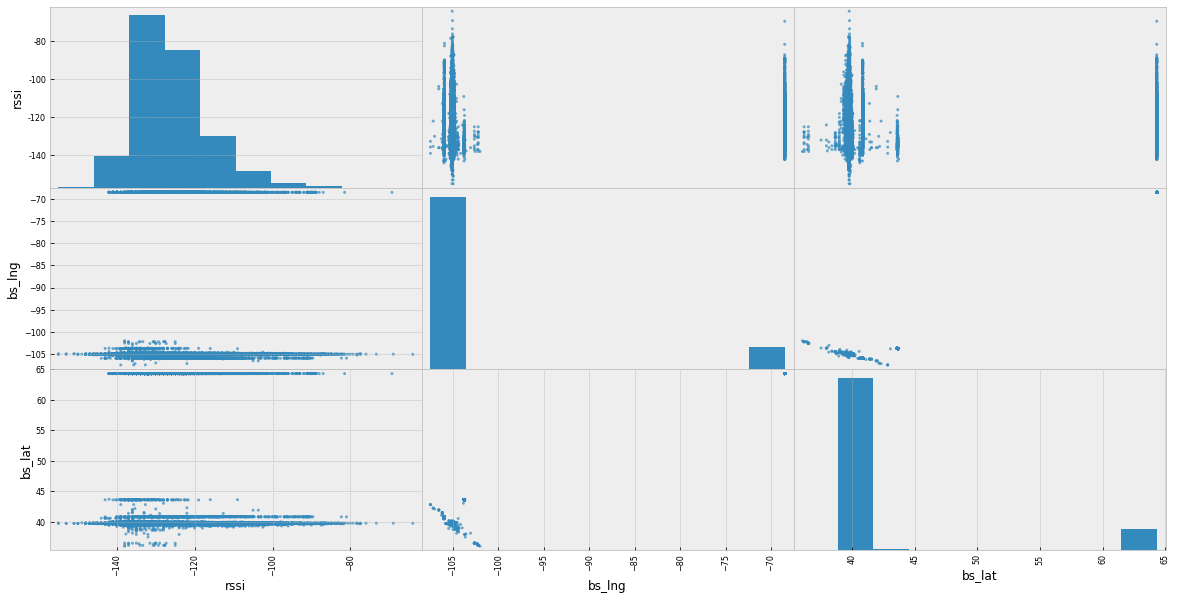

In [8]:
plt.style.use('bmh')
print(plt.style.available)

pd.plotting.scatter_matrix(df_mess_train[['rssi', 'bs_lng', 'bs_lat']], alpha=0.7, figsize=(20,10))
print('Pair plot on train set')
plt.show()

## 2. -  1ère approche : Relation linéaire RSSI / Distance puis régression XGBOOST

Notre première approche va consister à tenter de mettre en valeur la relation entre RSSI / distance et on démontrera l'insuffisance de ces données pour établir notre modèle : 
* l'affaiblissement n'est pas seulement fonction de la distance mais aussi du terrain, par exemple la densité du tissu urbain.
* On tentera alors d'enrichir notre modèle avec des données de densité de population donnant une indication supplémentaire pour expliquer l'affaiblissement.

### 2.1 Features Engineering

#### 2.1.1 Mise en valeur relation RSSI / Distance et limites

In [11]:
#Filtrage des outliers : données latitudes/longitudes aberrantes
arr=df_mess_train[df_mess_train['bs_lat'] < 60].index.values
df_train=df_mess_train.loc[arr,:]
df_train['lat']=pos_train.loc[arr,'lat']
df_train['lng']=pos_train.loc[arr,'lng']

In [12]:
#Fonction utilisant numpy pour calculer la distance
def distance_km(lat1,lng1,lat2,lng2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = np.radians(lat1)
    lng1 = np.radians(lng1)
    lat2 = np.radians(lat2)
    lng2 = np.radians(lng2)

    dlng = lng2 - lng1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

In [13]:
#Calcul de la distance
df_train['distance'] = distance_km(df_train.loc[:,'bs_lat'].values,
                                      df_train.loc[:,'bs_lng'].values,
                                      df_train.loc[:,'lat'].values,
                                      df_train.loc[:,'lng'].values)

In [14]:
#On se focalise sur les données des balises à moins de 40 km
#Filtrer distances incohérentes
arr2 = df_train[df_train['distance'] < 40].index.values
df_train=df_train.loc[arr2,:]

Text(0,0.5,'rssi')

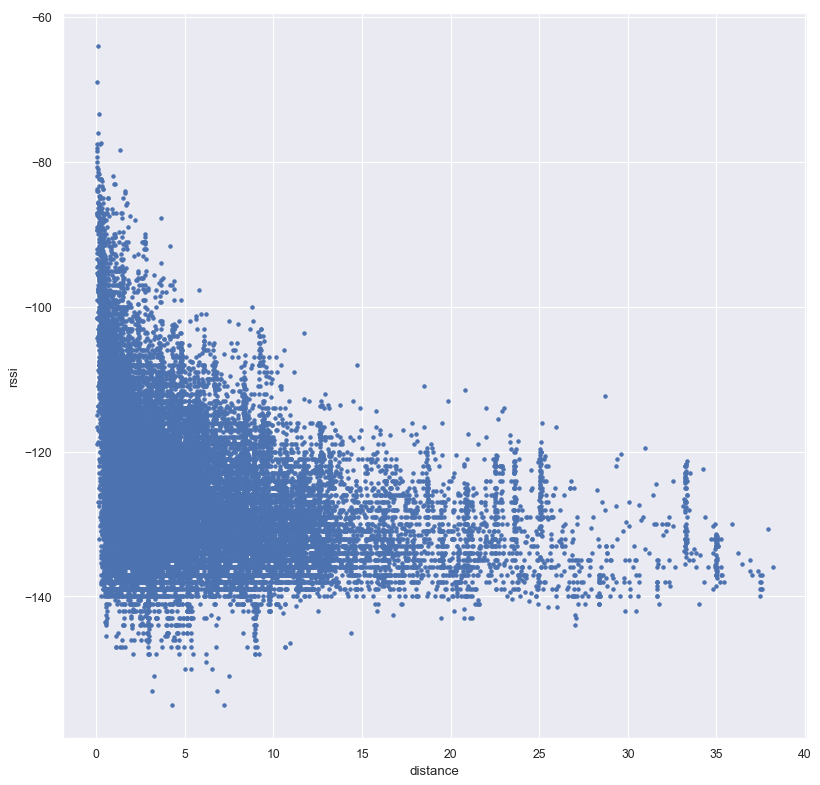

In [15]:
plt.figure(figsize=(12, 12), dpi=80)
plt.scatter('distance', 'rssi', marker='.',data=df_train);
plt.xlabel("distance")
plt.ylabel("rssi")

In [16]:
df_train.loc[:,['distance','rssi']].corr()

distance      rssi
distance  1.000000 -0.314137
rssi     -0.314137  1.000000

On voit qu'il existe effectivement une relation RSSI / distance 
mais celle-ci est imparfaite : certaines rssi très affaiblies sont pourtant issu de devices très proches
Une explication à ce phénomène serait la nature du terrain et notamment la densité urbaine.

L'idée serait d'ajouter cette information à notre modèle 
On va récupérer un fichier TIFF issue du jeu de données

Essayons de distinguer l'hyper-centre de la  zone urbaine de denver du reste 

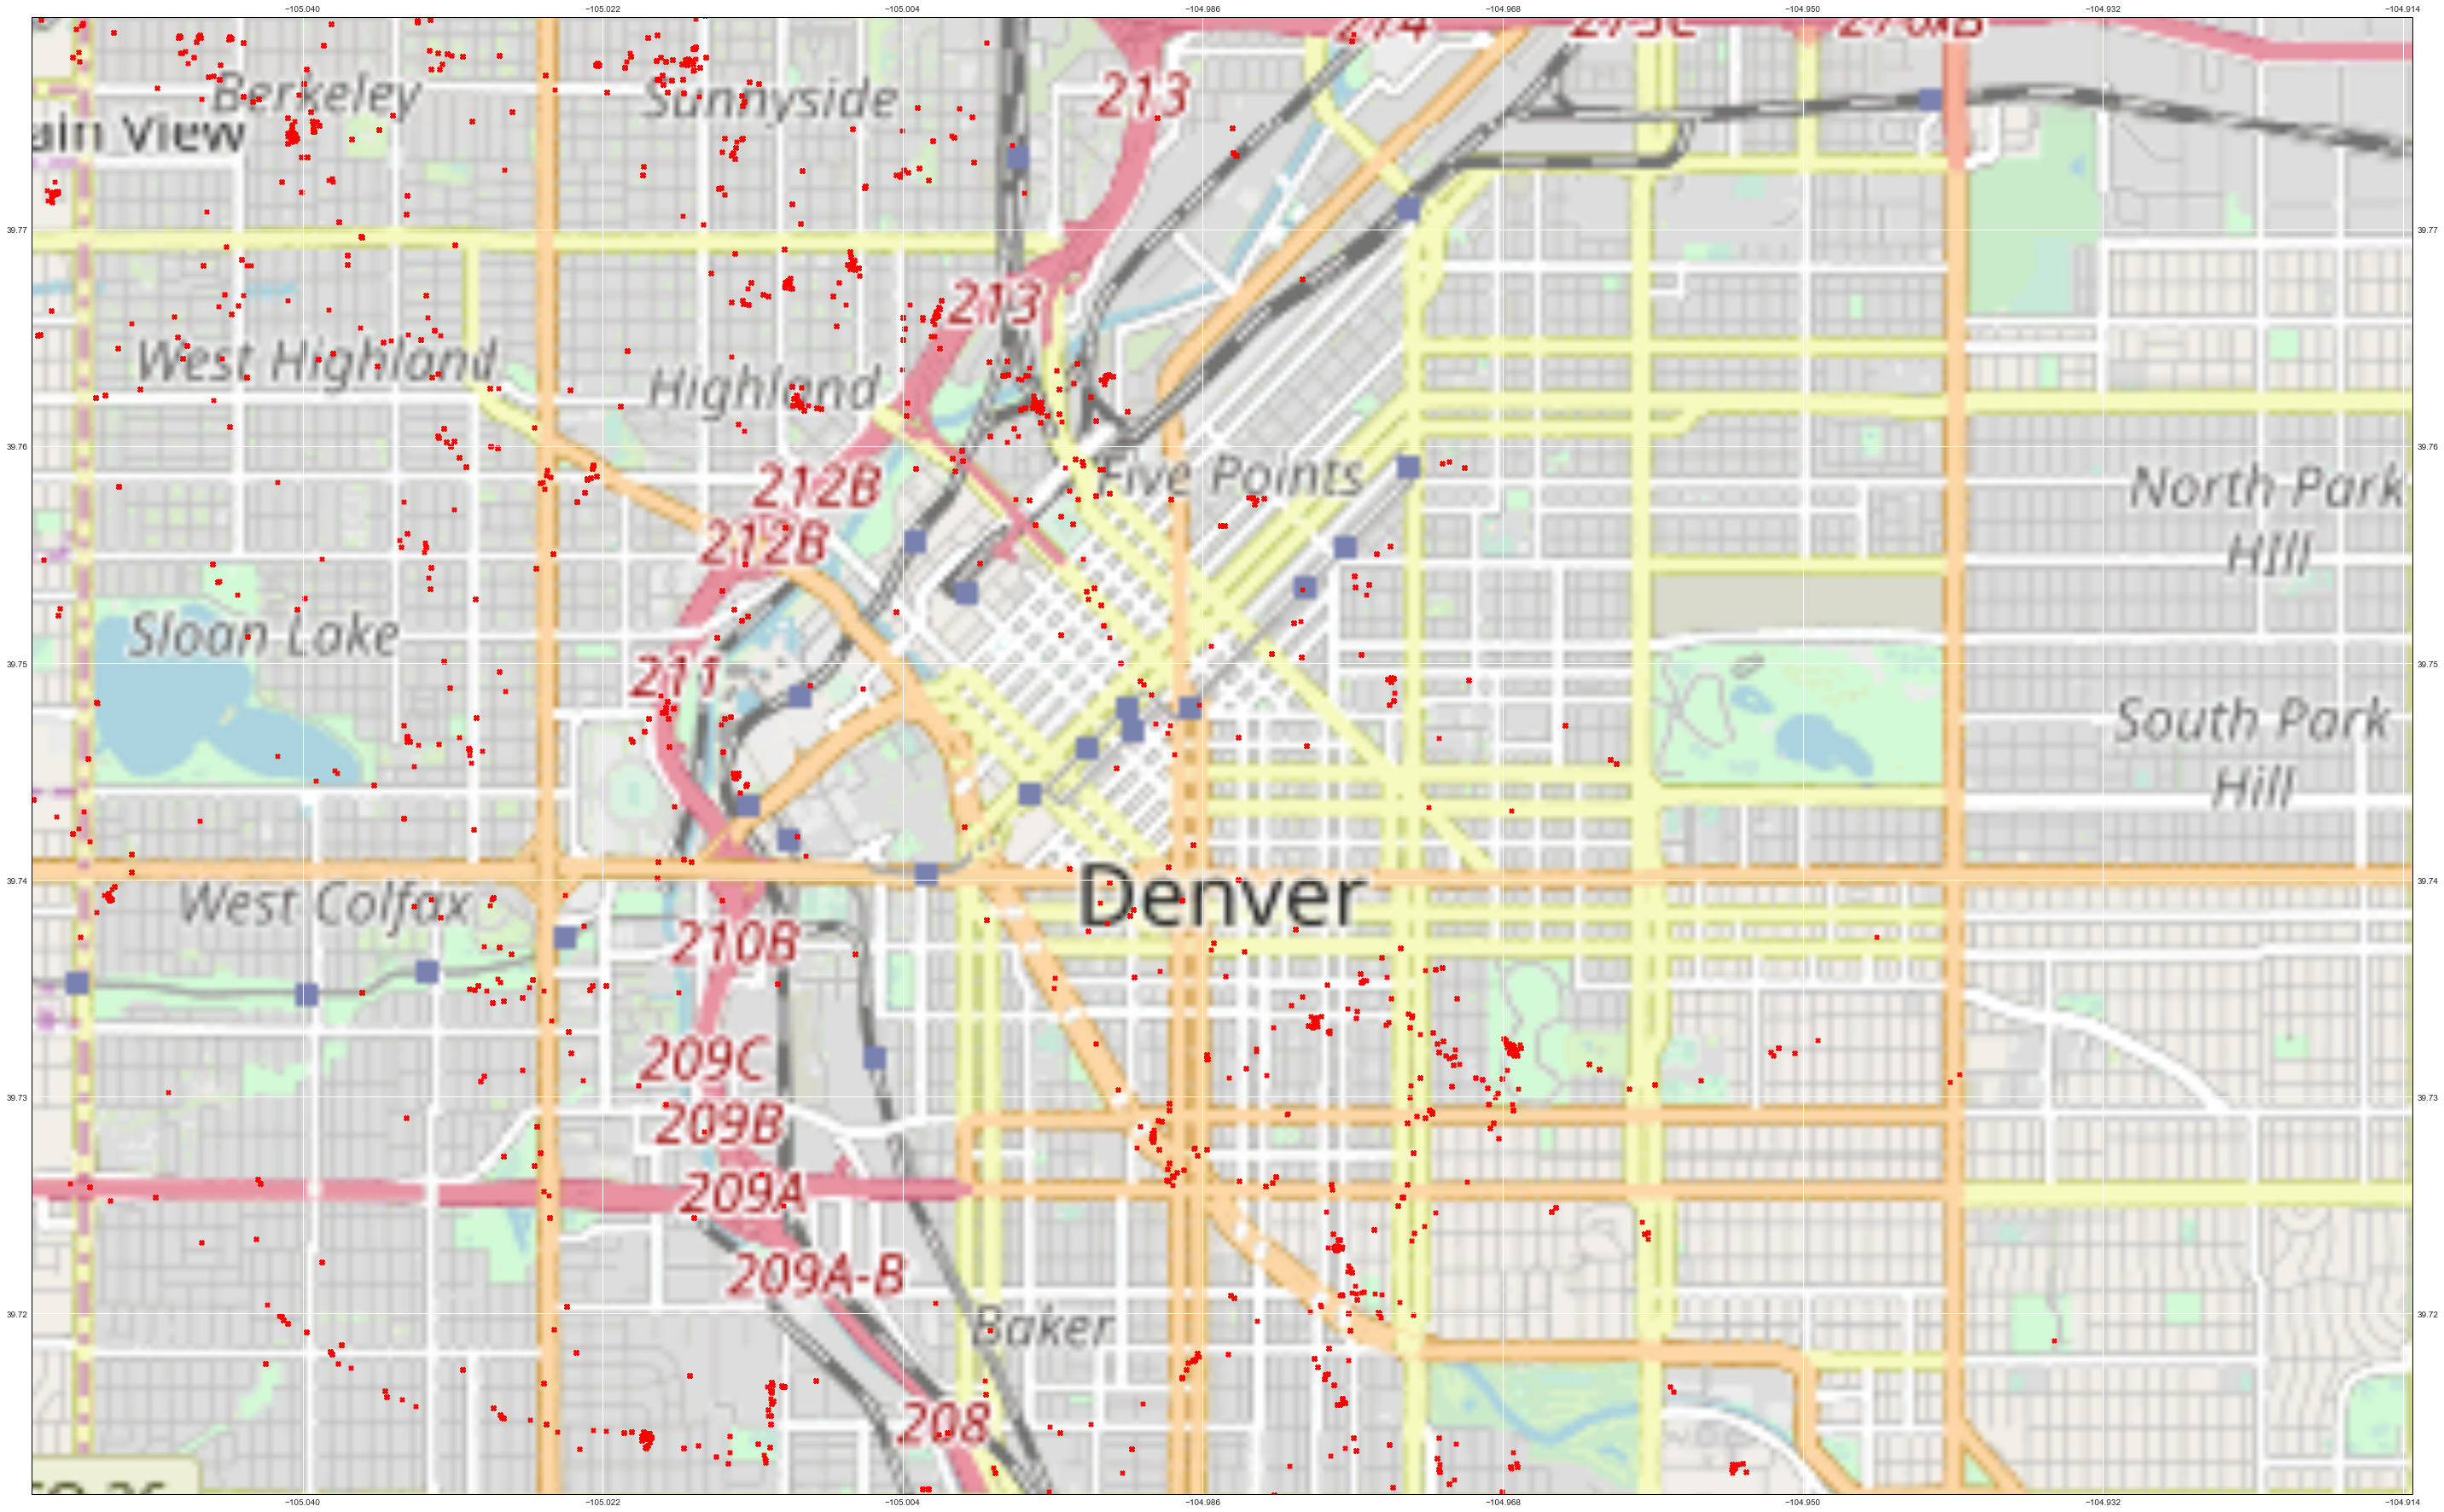

In [17]:
# Carto
fig = plt.figure(figsize=(50, 40))
osm_tiles = OSM()
ax = plt.axes(projection=osm_tiles.crs)

ax.set_extent([-105.05624771, -104.91342545, 39.71167663, 39.77978276])
ax.add_image(osm_tiles, 12,interpolation='bilinear')
ax.scatter('lng','lat',transform = ccrs.PlateCarree(),data=pos_train,s=30,marker='X',color='red')
ax.gridlines(draw_labels=True)
plt.show()

In [18]:
df_denver = df_train[(df_train['lat'] < 39.77978276) & (df_train['lat'] > 39.71167663) 
         & (df_train['lng'] > -105.05624771) & (df_train['lng'] < -104.91342545)]

Text(0,0.5,'rssi')

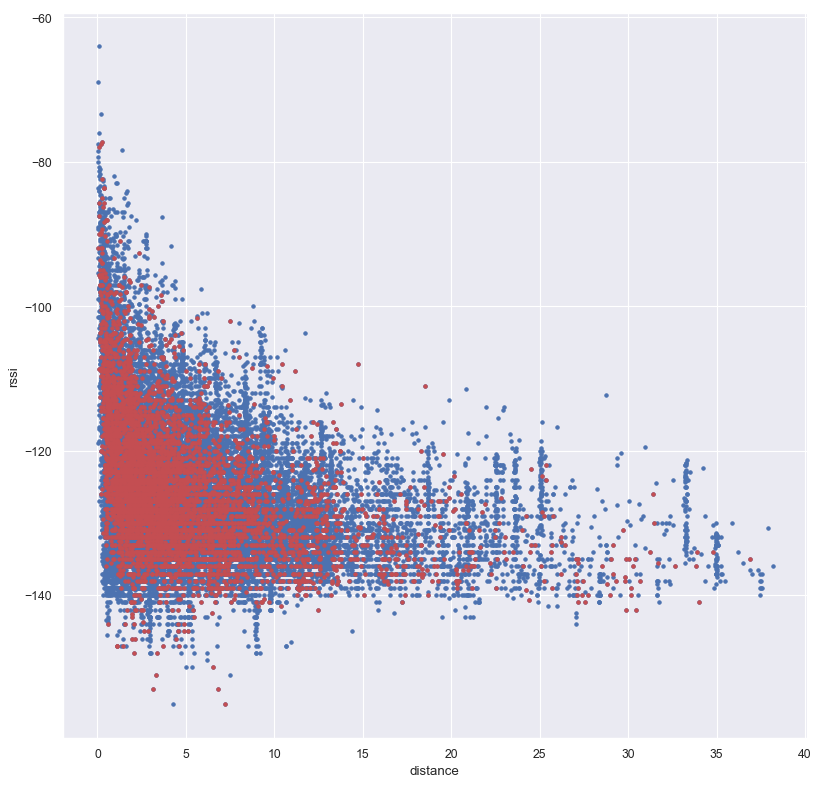

In [20]:
plt.figure(figsize=(12, 12), dpi=80)
plt.scatter('distance', 'rssi', marker='.',data=df_train);
plt.scatter('distance', 'rssi', marker='.',color='r',data=df_denver);
plt.xlabel("distance")
plt.ylabel("rssi")

On voit clairement que la densité urbaine (ici le centre de denver en rouge) 
permet d'expliquer en partie l'anomalie concernant le rssi.

Il faut pouvoir quantifier la densité urbaine dans laquelle se trouve la base station.

#### 2.1.2 Récuperation données de densité population ~ densité urbaine

On récupère les données densité de population sur le dataset Population Density du SEDAC
On se limitera aux données de 2015 et on restreindra la zone de recherche aux latitude/longitude min/max de 
notre jeu de donnée initial.
On récupera le jeu de donnée sous format GeoTiFF.
Chaque "pixel" du jeu de donnée represente un carré de 1km²
http://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density-rev10/data-download

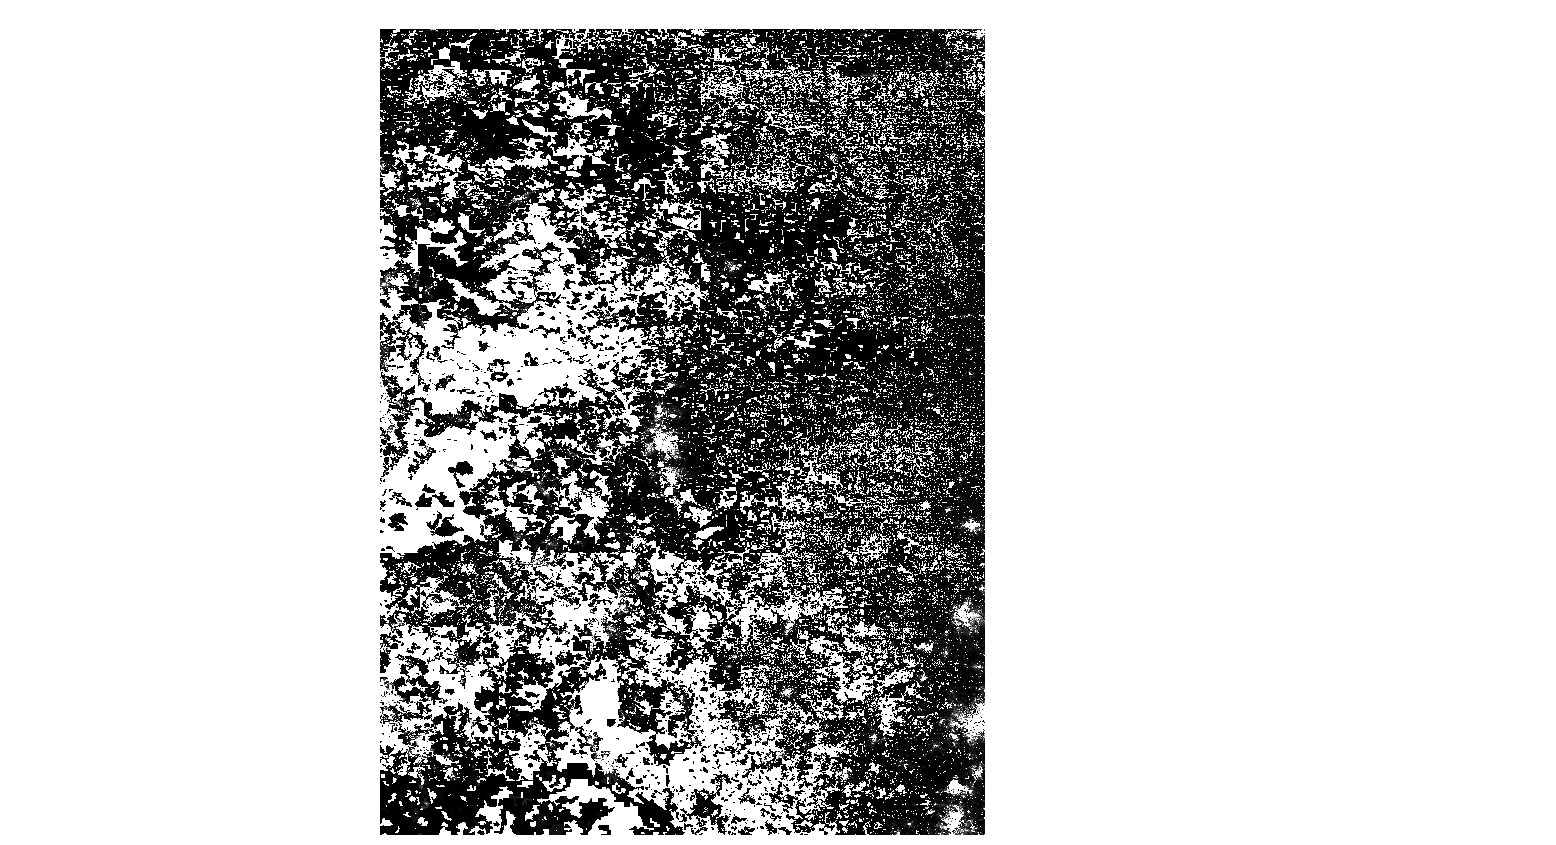

Data set description:
The population density rasters consist of estimates of human population (number of
persons per square kilometer), consistent with national censuses and population registers,
for the years 2000, 2005, 2010, 2015, and 2020. The rasters were created by dividing the
population count raster for a given target year by the land area raster. The files for this
data set were produced as global rasters at 30 arc-second horizontal resolution
(approximately 1 km at the equator). To enable faster global processing, and in support of
research communities, the 30 arc-second data count data were aggregated to 2.5 arc-
13
Documentation last revised 11/09/2017NASA Socioeconomic Data and Applications Center (SEDAC)
Documentation for Gridded Population of the World (GPW), v4
minute, 15 arc-minute, 30 arc-minute and 1 degree resolutions to produce density rasters
at these resolutions.

Data set web page:
http://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density-rev10

In [ ]:
#On joint les 2 jeux de données
import os

def get_value(lng,lat):
    result = os.popen('gdallocationinfo /data/Download/data_geoloc/usa_colorado.tif -valonly -wgs84 %s %s ' % (lng, lat)).read()
    return result.strip()

df_train['density'] = df_train.apply(lambda row: get_value(row['bs_lng'], row['bs_lat']), axis=1)

In [23]:
df_train.columns

Index(['messid', 'bsid', 'did', 'nseq', 'rssi', 'time_ux', 'bs_lat', 'bs_lng',
       'lat', 'lng', 'distance', 'density'],
      dtype='object')

In [46]:
#On se focalise sur les données des balises à moins de 40 km
#Filtrer distances incohérentes
arr2 = df_train[df_train['distance'] < 40].index.values
df_train=df_train.loc[arr2,:]

In [80]:
#On ramene les ratio négatifs ou nuls à 1
arr=df_train[(df_train['density'] <=0) | (df_train['density'].isnull())].index.values
df_train.loc[arr,'density']=1

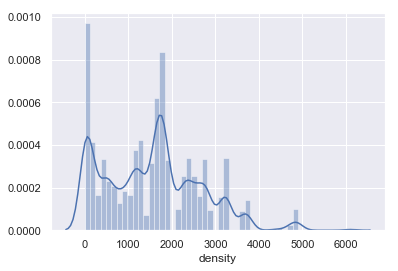

In [103]:
#Distribution de la densité
sns.distplot(df_train['density'])

In [104]:
#On va calculer le ratio rssi/density
#Un rssi plus elevé étrant meilleur, en divisant par la densité cela permet
#de remonter les rsignaux les plus affectés par la densité urbaine
df_train['rssi_density'] = df_train['rssi'] / df_train['density']

In [105]:
df_train['rssi_density'].head(5)

0   -0.735957
1   -0.046509
2   -0.087121
3   -0.085992
4   -0.088083
Name: rssi_density, dtype: float64

Text(0,0.5,'rssi')

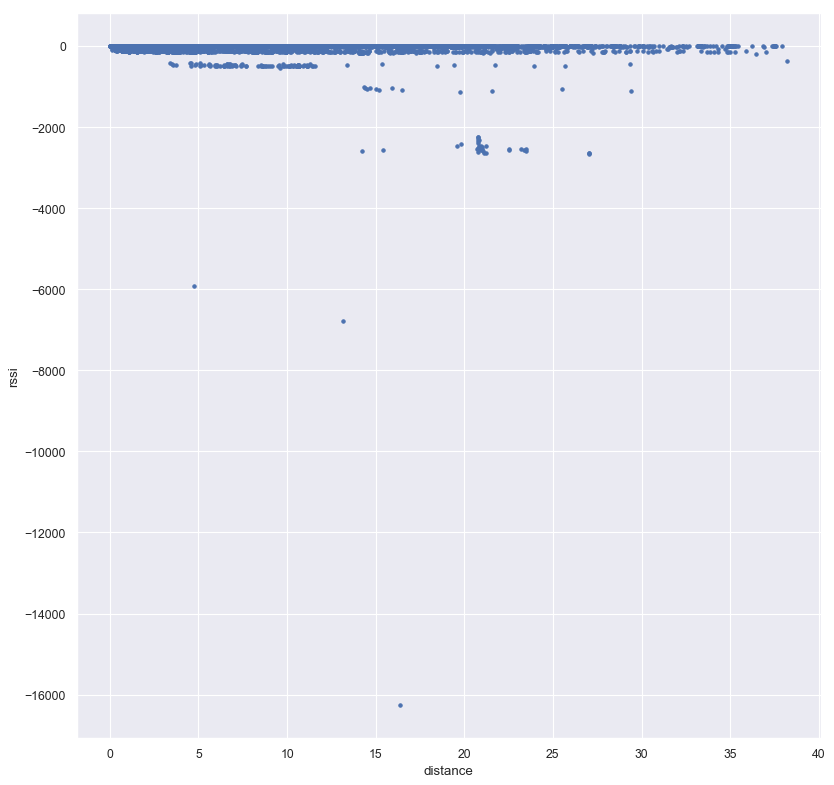

In [106]:
plt.figure(figsize=(12, 12), dpi=80)
plt.scatter('distance', 'rssi_density', marker='.',data=df_train);
plt.xlabel("distance")
plt.ylabel("rssi")

On peut maintenant passer à la partie modélisation, 
pour cela on porte notre choix sur la régression avec XGBoost.

### 2.2 Modélisation avec XGBOOST

On définit une feature matrix avec l'ensemble des stations et le rssi associé par station/message.
On définit un rssi par défaut à -2000 pour les stations n'ayant pas reçu le message

In [42]:
# Feature Matrix construction 
# rssi selon la station a reçu un message ou non

def feat_mat_const(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_feat.loc[idx,:] = -2000
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = df_mess_bs_group.get_group(key)['rssi_density'].values
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message 

In [43]:
def ground_truth_const(df_mess_train):
    df_mess_pos = df_mess_train.copy()

    ground_truth_lat = df_mess_pos.groupby(['messid']).mean()['lat']
    ground_truth_lng = df_mess_pos.groupby(['messid']).mean()['lng']
    
    return ground_truth_lat, ground_truth_lng

In [57]:
#Application du filtre sur les données
df_feat, id_list_train = feat_mat_const(df_train, listOfBs)
ground_truth_lat, ground_truth_lng = ground_truth_const(df_train)
df_feat.head(10)

879     911     921     944     980     1012         1086    1092   \
0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.000000 -2000.0   
1 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.000000 -2000.0   
2 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.000000 -2000.0   
3 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.000000 -2000.0   
4 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0   -61.437974 -2000.0   
5 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.000000 -2000.0   
6 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.000000 -2000.0   
7 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.000000 -2000.0   
8 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.000000 -2000.0   
9 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.000000 -2000.0   

    1120    1131    ...     9936    9941    9949    10134   10148   10151  \
0 -2000.0 -2000.0   ...   -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0   
1 -2000.0 -2000.0   ...   -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0   
2 -2000.0 -2000.0   ...   -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0   
3 -2000.0 -2000.0   ...   -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0   
4 -2000.0 -2000.0   ...   -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0   
5 -2000.0 -2000.0   ...   -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0   
6 -2000.0 -2000.0   ...   -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0   
7 -2000.0 -2000.0   ...   -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0   
8 -2000.0 -2000.0   ...   -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0   
9 -2000.0 -2000.0   ...   -2000.0 -2000.0 -2000.0 -2000.0 -2000.0 -2000.0   

    10162   10999   11007   11951  
0 -2000.0 -2000.0 -2000.0 -2000.0  
1 -2000.0 -2000.0 -2000.0 -2000.0  
2 -2000.0 -2000.0 -2000.0 -2000.0  
3 -2000.0 -2000.0 -2000.0 -2000.0  
4 -2000.0 -2000.0 -2000.0 -2000.0  
5 -2000.0 -2000.0 -2000.0 -2000.0  
6 -2000.0 -2000.0 -2000.0 -2000.0  
7 -2000.0 -2000.0 -2000.0 -2000.0  
8 -2000.0 -2000.0 -2000.0 -2000.0  
9 -2000.0 -2000.0 -2000.0 -2000.0  

[10 rows x 259 columns]

In [58]:
#Regression basé sur Xgboost
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng):   
    reg = XGBRegressor(                     
                      objective='reg:linear',
                      n_estimators=1000, 
                      n_jobs=-1,
                      random_state=42,
                      max_depth = 9,
                      tree_method = 'gpu_hist',
                      max_bin = 512,
                      learning_rate=0.1,
                      eta=0.1)
    
    
    # Multiple output regressor
    reg = MultiOutputRegressor(reg)
    y = pd.concat([ground_truth_lat, ground_truth_lng], axis=1)
    y_pred = cross_val_predict(reg, df_feat, y, cv=10)
    y_pred_lat = y_pred[:, 0]
    y_pred_lng = y_pred[:, 1]
    
    return y_pred_lat, y_pred_lng

In [59]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [distance(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [60]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))   
    return err_vec

In [65]:
# Learning and predicting on full training set
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng)
# Measuring error on the full training set
err_vec = Eval_geoloc(ground_truth_lat, ground_truth_lng, y_pred_lat, y_pred_lng)

Critère de prédiction: 4.40 km


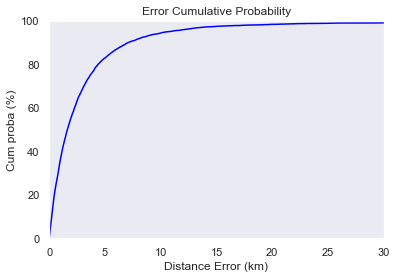

In [66]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values)
plt.figure()
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid()
plt.xlabel('Distance Error (km)')
plt.ylabel('Cum proba (%)')
plt.axis([0, 30, 0, 100])
_ = plt.title('Error Cumulative Probability')
print("Critère de prédiction: %2.2f km" %(np.percentile(err_vec, 80) / 1000))

## 3. Metric Learning  & KNN

La méthode XGBOOST n'a pas donné des résultas satisfaisants  , de ce fait , on va essayer d'autres approches.
Notre seconde approche consiste à créer une métrique qui mesure la distance entre deux messages en se basant sur leurs vecteurs des RSSis . 
Pour ce faire,  on utilisera une approche supervisée :

*  On part de la matrice des features basée uniquement sur les RSSI  
*  Pour chaque couple de messages on calcule des features de distance ( norm1 ,norm 2) et la distance de vincenty ( c'est notre target )
* On contruit une matrice de features et un vecteur de distance . A partir de cela on estime un modèle qui sera notre metric pour la problématique de géolocalisation 


### 3.1 Features Engineering 

#### 3.1.1 -Matrice des features avec les RSSi 

Le format de données choisi est le suivant: On retrouve les messages en lignes et toutes les bases en colonnes. Puis la matrice contient, pour chaque message, la puissances du signal pour les bases qui ont reçues le message. Dans le cas où le message n'est pas recu par certaines bases, la valeur ( min ( Rssi) - 200 ) est mise. 

Remarque : On a essayé des autres matrices de features basées à la fois sur les coordonnées des stations et les RSSis mais cela n'a pas amélioré la performance .

In [73]:
def feat_mat_const_rssi(train, listOfBs):
    
    min_rssi = train["rssi"].min() - 200  ### initialiser les RSSi
    messages = train[colmessage].unique()
    columns = []
    list(map(lambda bs: columns.append(str(bs)), listOfBs))
    
    df_feat = pd.DataFrame(index= messages, columns= columns)
    df_feat[df_feat.columns[:len(listOfBs)]] = df_feat[df_feat.columns[:len(listOfBs)]].fillna(min_rssi)
    #df_feat[df_feat.columns[len(listOfBs):]] = df_feat[df_feat.columns[len(listOfBs):]].fillna(min_rssi_lng)
    
    # Pour chaque station recevant le message
    for i,message in enumerate(messages):
        bsids = train[train[colmessage] == message]["bsid"]
        for bsid in bsids:
            rssi = train[(train[colmessage] == message) & (train["bsid"] == bsid)]["rssi"].iloc[0]
            df_feat.loc[message, (str(bsid))] =  rssi
        if i%2000==0 :  ## verbose
            print("%s messages processed" %i)
    return df_feat

On a essayé de convertir le RSSi en dbM ( voir ci-dessous) mais cela a gonflé l'erreur de prédiciton final du modèle . De ce fait on a abondonné cette piste.

In [51]:
############################ conversion en dbm_to_mw #####################
def dbm_to_mw(dBm):
    return 10**((dBm)/10.)

df_mess_train_mw=df_mess_train.copy()
df_mess_train_mw['rssi'] = df_mess_train_mw['rssi'].apply(dbm_to_mw)


In [52]:
df_mess_train_mw.head()

messid  bsid       did  nseq      rssi       time_ux  \
0  573bf1d9864fce1a9af8c5c9  2841  473335.0   0.5  0.707946  1.463546e+12   
1  573bf1d9864fce1a9af8c5c9  3526  473335.0   2.0  0.316228  1.463546e+12   
2  573bf3533e952e19126b256a  2605  473335.0   1.0  0.039811  1.463547e+12   
3  573c0cd0f0fe6e735a699b93  2610  473953.0   2.0  0.063096  1.463553e+12   
4  573c0cd0f0fe6e735a699b93  3574  473953.0   1.0  1.000000  1.463553e+12   

      bs_lat      bs_lng  
0  39.617794 -104.954917  
1  39.677251 -104.952721  
2  39.612745 -105.008827  
3  39.797969 -105.073460  
4  39.723151 -104.956216

On génère la matrice des features sur le train 

In [74]:
############################# la matrice des features ##########################
df_feat= feat_mat_const_rssi(df_mess_train, listOfBs)

0 messages processed
2000 messages processed
4000 messages processed
6000 messages processed


#### 3.1.2  Calcul du Ground Truth

In [75]:
# ground truth construction
def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby([colmessage]).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby([colmessage]).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

#### 3.1.3 Normalisation des données 

Ici on normalise par une constante fixe égale à à la valeur minimale des RSSis - 200 

In [20]:
####################################### Normalisation  ##################################################
cst_normalisation =abs(df_mess_train["rssi"].min() - 200 )
print("La constante de normalisation est %s" %cst_normalisation)
df_feat=df_feat/cst_normalisation


La constante de normalisation est 355.0


In [55]:
df_feat.head()

879  911  921  944  980  1012      1086  1092  1120  \
573bf1d9864fce1a9af8c5c9  0.0  0.0  0.0  0.0  0.0   0.0  0.000000   0.0   0.0   
573bf3533e952e19126b256a  0.0  0.0  0.0  0.0  0.0   0.0  0.000000   0.0   0.0   
573c0cd0f0fe6e735a699b93  0.0  0.0  0.0  0.0  0.0   0.0  0.000000   0.0   0.0   
573c1272f0fe6e735a6cb8bd  0.0  0.0  0.0  0.0  0.0   0.0  0.000000   0.0   0.0   
573c8ea8864fce1a9a5fbf7a  0.0  0.0  0.0  0.0  0.0   0.0  0.007943   0.0   0.0   

                          1131  ...    9936  9941  9949  10134  10148  10151  \
573bf1d9864fce1a9af8c5c9     0  ...       0     0     0    0.0    0.0    0.0   
573bf3533e952e19126b256a     0  ...       0     0     0    0.0    0.0    0.0   
573c0cd0f0fe6e735a699b93     0  ...       0     0     0    0.0    0.0    0.0   
573c1272f0fe6e735a6cb8bd     0  ...       0     0     0    0.0    0.0    0.0   
573c8ea8864fce1a9a5fbf7a     0  ...       0     0     0    0.0    0.0    0.0   

                          10162  10999  11007  11951  
573bf1d9864fce1a9af8c5c9    0.0    0.0    0.0    0.0  
573bf3533e952e19126b256a    0.0    0.0    0.0    0.0  
573c0cd0f0fe6e735a699b93    0.0    0.0    0.0    0.0  
573c1272f0fe6e735a6cb8bd    0.0    0.0    0.0    0.0  
573c8ea8864fce1a9a5fbf7a    0.0    0.0    0.0    0.0  

[5 rows x 259 columns]

On recupère le ground truth  ( les valeurs réelles des longitudes et latitude du message) et on les ajoute aux features

In [76]:

#######################  ground truth long & lat ##########################
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)

###################### df_metric contient les featres + ground_truth long & lat 
df_metric=df_feat.copy()
df_metric['lat']=ground_truth_lat
df_metric['lng']=ground_truth_lng
print ( " The shape of our data : (%s,%s)" %(df_metric.shape[0],df_metric.shape[1]))
df_metric.head()


 The shape of our data : (6068,261)


879    911    921    944    980   1012   1086  \
573bf1d9864fce1a9af8c5c9 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0   
573bf3533e952e19126b256a -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0   
573c0cd0f0fe6e735a699b93 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0   
573c1272f0fe6e735a6cb8bd -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0   
573c8ea8864fce1a9a5fbf7a -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -141.0   

                           1092   1120   1131     ...       9949  10134  \
573bf1d9864fce1a9af8c5c9 -355.0 -355.0 -355.0     ...     -355.0 -355.0   
573bf3533e952e19126b256a -355.0 -355.0 -355.0     ...     -355.0 -355.0   
573c0cd0f0fe6e735a699b93 -355.0 -355.0 -355.0     ...     -355.0 -355.0   
573c1272f0fe6e735a6cb8bd -355.0 -355.0 -355.0     ...     -355.0 -355.0   
573c8ea8864fce1a9a5fbf7a -355.0 -355.0 -355.0     ...     -355.0 -355.0   

                          10148  10151  10162  10999  11007  11951        lat  \
573bf1d9864fce1a9af8c5c9 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0  39.606690   
573bf3533e952e19126b256a -355.0 -355.0 -355.0 -355.0 -355.0 -355.0  39.637741   
573c0cd0f0fe6e735a699b93 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0  39.730417   
573c1272f0fe6e735a6cb8bd -355.0 -355.0 -355.0 -355.0 -355.0 -355.0  39.693102   
573c8ea8864fce1a9a5fbf7a -355.0 -355.0 -355.0 -355.0 -355.0 -355.0  39.758167   

                                 lng  
573bf1d9864fce1a9af8c5c9 -104.958490  
573bf3533e952e19126b256a -104.958554  
573c0cd0f0fe6e735a699b93 -104.968940  
573c1272f0fe6e735a6cb8bd -105.006995  
573c8ea8864fce1a9a5fbf7a -105.051016  

[5 rows x 261 columns]

####  3.1.4 Fonction permettant le calcul de la distance "Vincenty"

In [26]:
################### Vincenty distance #########################

def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

#### 3.1.5 Les features de distance
Comme features , on utilisera la norm 1 et la norme moyenne  des composantes des vecteurs.
Notre target est la distance vincenty entre chaque couple d'observation.
Pour le construction du modèles , on se limitera à 10% des combinaisons possibles des messages .

In [77]:

######################################   Preparing Dataframe for metric learning ############################################""
## on prend uniquement 10% des couples aléatoirement , c'est déjà assez .
mat_metric=np.array(df_metric.sample(frac=0.1))

##norme 1 : valeur absolue des coordonnées deux à deux
values_norm1=[abs(i[:-2] - j[:-2]) for i, j in it.combinations(mat_metric, 2)]

## norm a+b/ 2 
values_normsum=[(i[:-2] +j[:-2])/2 for i, j in it.combinations(mat_metric, 2)]

## vincenty distance entre chaque couple de message
vicenty_dist=[vincenty_vec(np.transpose( np.array([[i[-2]] , [i[-1]], [j[-2]], [j[-1]]])))[0] for i, j in it.combinations(mat_metric, 2)]


/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


In [78]:
################# combining features ##############################
mat_feat_metric=pd.concat([pd.DataFrame(values_norm1),pd.DataFrame(values_normsum)], axis=1)

In [79]:
mat_feat_metric.shape

(183921, 518)

#### 3.1.6 Split du dataset en train et test

In [80]:
random_seed = 42
X_train_metric, X_test_metric, y_train_metric, y_test_metric = train_test_split(mat_feat_metric, vicenty_dist,
                                                    train_size=0.85, random_state=random_seed)

print(X_train_metric.shape)
print(X_test_metric.shape)

/home/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(156332, 518)
(27589, 518)


### 3.2  Modélisation de la distance
Pour l'estimation du modèle de metric learning , on utilisera une variété des RandomForests qui s'appelle extratreeRegressors

In [81]:
################ simple model #######################################
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

reg_metric= ExtraTreesRegressor(n_estimators=10, n_jobs=2)

reg_metric.fit(X_train_metric,y_train_metric)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

Maintenant ,on évalue le modèle sur l'échantillon du test

In [82]:
print("Le score du modèle sur l'échantillon test est %.2g " %reg_metric.score(X_test_metric,y_test_metric)

0.9995635437873021

### 3.3 KNN en utilisant la nouvelle métrique

Après avoir créer et valider la nouvelle métrique ,essayons maintenant de l'utiliser comme une mesure de distance  pour KNN . 


#### 3.3.1 Splitter les données 

In [83]:
random_seed = 42
################################ splitting the data ###################
X_train, X_test, y_train, y_test = train_test_split(df_feat, np.transpose([ground_truth_lat, ground_truth_lng]),
                                                    train_size=0.9, random_state=random_seed)

print(X_train.shape)
print(X_test.shape)

(5461, 259)
(607, 259)


/home/user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [84]:
X_train.head(5)

879    911    921    944    980   1012   1086  \
57f29cb712f143344c9eec25 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0   
57c6be81cf554f465aa97df6 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0   
5774cd6012f1436ef8cc203b -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0   
57eed4d0cf554f7f69a3e51d -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0   
57f73c14cf554f7f691eb346 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0   

                           1092   1120   1131  ...     9936   9941   9949  \
57f29cb712f143344c9eec25 -355.0 -355.0 -355.0  ...   -355.0 -355.0 -355.0   
57c6be81cf554f465aa97df6 -355.0 -355.0 -355.0  ...   -355.0 -355.0 -355.0   
5774cd6012f1436ef8cc203b -355.0 -355.0 -355.0  ...   -355.0 -355.0 -355.0   
57eed4d0cf554f7f69a3e51d -355.0 -355.0 -355.0  ...   -355.0 -355.0 -355.0   
57f73c14cf554f7f691eb346 -355.0 -355.0 -355.0  ...   -355.0 -355.0 -355.0   

                          10134  10148  10151  10162  10999  11007  11951  
57f29cb712f143344c9eec25 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0  
57c6be81cf554f465aa97df6 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0  
5774cd6012f1436ef8cc203b -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0  
57eed4d0cf554f7f69a3e51d -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0  
57f73c14cf554f7f691eb346 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0 -355.0  

[5 rows x 259 columns]

#### 3.3.2 Une fonction pour évaluer l'erreur de prédiction

In [12]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat, y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    return err_vec

#### 3.3.3 Création de KNN from scratch


Le calcul de distance au niveau de la classe  KNeighborsRegressor de sklearn n'est pas parallélisé et l'algorithme prend enormément du temps pour s'éxécuter sur un jeux de données de taille considérable . De ce fait , on a implémenté une version de KNN "from scratch" avec un calcul vectoriel de distance . 
Comme on travaille sur une problématique de régression , le KNN consiste à trouver les k plus proche voisins de chaque message et moyenner leurs positions ( longitude et latitude ) . Dans notre contexte ,on utilisera la médiane des positions au lieu de la moyenne pour éviter les outliers . 


In [92]:

from sklearn.base import BaseEstimator, ClassifierMixin


########## calcul distance entre tous les pair #####
def pairwise_callable(X, Y):
    """Handle the callable case for pairwise_{distances,kernels}
    """
    out = np.empty((X.shape[0], Y.shape[0]), dtype='float')
    for i in range(X.shape[0]):
        #if i % 100 ==0 :
            #print(i)
        out[i,:] = myfunc(X[i], Y)
    return out

##########   Fonction qui renvoie la distance entre deux obs  ################""
def myfunc(x, y):
    ret1 = (abs(x - y)) 
    ret2 = (0.5 * (x+y)) 
    return reg_metric.predict(np.hstack([ret1,ret2]))

##########  KNN   #############
class KNNRegressorCustMet(BaseEstimator, ClassifierMixin):
    """ Homemade kNN classifier class """
    # Constructeur
    def __init__(self, n_neighbors=8):
        self.k=n_neighbors
    # Fit : pas de train  
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self
    # Calcul des distances, rankiong, et sélection
    def predict(self, X,r=None):
        distances = pairwise_callable(X,self.X_train)
        ix = np.argsort(distances,axis=1)
        neighbours_sel_indices = ix[:,0:self.k]
        neighbours_sel = self.y_train[neighbours_sel_indices]
        return(np.median(neighbours_sel,axis=1))  ###  on prend la médiane pour éviter les outliers

#### 3.3.4 Fitter le modèle et calcul d'erreur de prédiction
Ici , on estime la latitude et la longitude séparement en utilisant KNN avec la nouvelle métrique

In [96]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test,kneighbors):
    print (" Training KNN for k = %s ..." %kneighbors)
    X_train =df_feat
    
    ######### définir le classifieur ##########
    reg =KNNRegressorCustMet(n_neighbors=kneighbors)
    
    ######### fit et prédict le modèle lat ##########
    reg.fit(X_train, ground_truth_lat)
    y_pred_lat = reg.predict(df_test.values)
    
    
    ######### fit le modèle long ##########
    reg.fit(X_train, ground_truth_lng)
    y_pred_lng = reg.predict(df_test.values)

    return y_pred_lat, y_pred_lng

#####" liste des paramètres k à tester"
k_listparameters =[5,8,15,20,25]
for kn in k_listparameters :
    y_pred_lat, y_pred_lng = regressor_and_predict(X_train, y_train[:, 0], y_train[:, 1], X_test,kn)
    err_vec = Eval_geoloc(y_test[:, 0] , y_test[:, 1], y_pred_lat, y_pred_lng)
    print("Critère de prédiction pour k = %s : %2.2f km" %(kn,(np.percentile(err_vec, 80) / 1000)))

 Training KNN for k = 5 ...


/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


Critère de prédiction pour k = 5 : 5.53 km
 Training KNN for k = 8 ...
Critère de prédiction pour k = 8 : 4.65 km
 Training KNN for k = 15 ...
Critère de prédiction pour k = 15 : 4.18 km
 Training KNN for k = 20 ...
Critère de prédiction pour k = 20 : 4.39 km
 Training KNN for k = 25 ...
Critère de prédiction pour k = 25 : 4.55 km


La meilleure valeur de k est 15 , l'erreur de prédiction associée est 4.18 km . 
Maleureusement , on ne réalise pas de gain par rapport à la première méthode et les résultats de prédiction de cette approche sont similaires à ceux de la modélisation supervisée classique avec XGBOOST 

## 4  KNN adaptatifs

Une approche, plus simple des KNN a au final été retenue : 

La modélisation en utilisant les vecteurs de puissance (rssi), approche judicieuse et largement répendue dans la littérature, a été ici conservée. La question du choix et du calcul de la métrique restait donc posée pour estimer la position par rapport à cette mesure de dispersion entre les vecteurs de puissance.  

Une recherche exhaustive sur l'ensemble des distances disponibles dans les algorithmes a été réalisée. Les distances précédemment testées ont également été prises en considération. Au final la distance de Minkowski ($sum(|x - y|^p)^{(1/p)}, p=5$) a été retenue.

Le nombre de voisins à considéré a été tuné à 7 par validation croisée.

Un premier ajustement a été tenté : pondérer la simple moyenne opérée sur les voisins considérés en fonction de leur proximité. Plusieurs pondérations ont été testées (exp(-x), 1/d, ...) améliorant sensiblement les résultats. La pondération a cependant trop tendance à opérer un cut-off trop importants  sur les derniers voisins, ayant pour conséquence globale de réduire le nombre de voisins considérés. Autre inconvénient : bien que les performances soient améliorées sur l'échantillon de test, le procédé créé un réel écart entre le train et le test (fort sur apprentissage en train). Ce chemin a donc été finalement écarté.

A partir de ce premier essai, les erreurs ont été analysées, révélant une forte moyenne et une grande dispersion pour les messages captés par peu de balises, et notemment un très fort poids porté par les messages reçus par une unique balise. Un simple abaissement du nombre de voisins à considérer dans ces cas augmentait sensiblement les performances. Le nombre de bs réceptrices a donc été intégré à la matrice de feature, et le knn adapté et tuné pour prendre en compte un nombre différent de voisins selon ce paramètre ("Adaptive KNN"). Au final, une légère amélioration. 

La vraie difficulté réside dans la présence d'outliers, de données erronnées ou falisifiées, rendant la tâche de généralisation très difficile. D'abord focalisés sur les bs très éloignées (> 40km), les balises "anormales" ne posent au final pas trop de souci pour la stabilité par estimation sur les puissances de signal. En revanche, un certain nombre de positions de messages posent question. Des essais d'exclusion d'une partie des messages identifiés des jeux d'apprentissage et test ont été réalisés mais sans arriver à en déterminer l'exhaustivité ni comprendre la réelle nature de ces bruits. Une première sélection cepedant été réalisée manuellement, en analysant les trajectoires des devices comportant des points très surprenants. Des sauts dans ces trajectoires ont pu être identifiés, laissant penser à des modifications de données ou dans certains cas à des trajets exceptionnels pour des devices plutôt habituellement urbaines et relativement statiques. Les messages associés n'ont cependant pas été exclus car l'amélioration globale sur ces quelques exclusions ponctuelle n'était pas concluante, et la nature réelle du phénomène incomprise. Il conviendrait d'avancer d'avantages dans cette voie afin d'établir une méthodologie pour isoler/retraiter automatiquement ces points et ajouter de la précision et de la consitence aux modèles proposés. Venant à cette conclusion tardivement, nous n'avons pas eu le temps d'investiguer plus sur le sujet, mais la clé se situe sans nul doute dans l'isolation/le traitement de ce bruit. 

Au final, la méthode des "adaptives KNN" obtient en moyenne sur 100 folds, une erreur de 2 879m en validation. C'est avec ce dernier modèle que l'échantillon de test a été scoré. 

Les programmes ci-dessous restitués pour cette dernière approche contiennent uniquement les derniers runs exécutés, reflétant que partiellement les mutliples essais et occultant les phases de tuning et reserrements de périmètre d'apprentissage. 

La trame restituée dans cette démarche est la suivante : 
- Prétraitements : contructionde la matrice de features avec ajout du nombre de balises réceptrices par message et d'une catégorisation de ce champs (quelques plot de distribution sur ce champs) ; ajout de la cible à la matrice de features ; échantillonnage simple servant pour une première évaluation des modèles
- Modélisation : knn adaptatifs, fit et scoring sur les trains et validation set.
- Anomalies : un exemple de première piste de réflexion sur les points abérrants
- Validation croisée à 100 folds sur le modèle retenu
- Scoring du jeu de test en vue de la soumission

**_Point d'attention :_** l'ordre initial des données de test n'est pas forcément respecté. La clé (**messid**) est néanmoins associée aux prédictions 

### 4.1 Features Engineering 

#### 4.1.1 -Matrice des features avec les RSSi 

Conservation de la matrice de vecteurs puissance avec ajout du nombre de stations réceptrices ainsi qu'une catégorisation

In [6]:
def feat_mat_const_new(df, listOfBs):  
    min_rssi = -250.0
    mess_unique = df["messid"].unique()
    idx = 0
    id_list = [0] * len(mess_unique)
    
    columns = []
    list(map(lambda bs: columns.append(str(bs) + "_rssi"), listOfBs))
    
    df_feat = pd.DataFrame(index= mess_unique, columns= columns)
    df_feat[df_feat.columns[:len(listOfBs)]] = df_feat[df_feat.columns[:len(listOfBs)]].fillna(min_rssi)
    
    # Pour chaque station recevant le message
    for message in mess_unique:
        bsids = df[df["messid"] == message]["bsid"]
        for bsid in bsids:
            rssi = df[(df["messid"] == message) & (df["bsid"] == bsid)]["rssi"].iloc[0]
            df_feat.loc[message, (str(bsid)+"_rssi" )] = rssi
            
    # Calcul du nombre de stations réceptrices
    s_gpby = df.groupby(['messid'])['messid'].count().sort_values(ascending=False)
    df_gpby = pd.DataFrame(s_gpby)
    df_gpby.rename(columns={"messid": "nb_stations"},inplace = True)
    df_gpby = df_gpby.reset_index()
    df_feat= df_feat.reset_index()
    df_feat.rename(columns={"index": "messid"},inplace = True)
    df_feat2 = pd.merge(df_feat,df_gpby, on='messid')
    
    bins = [0,1, 2, 3, 5, 10,110]
    labels2 = [1,2,3,4,5,6]

    df_feat2['binned_num'] = pd.cut(df_feat2['nb_stations'], bins=bins, labels=labels2)
    
    return df_feat2

In [7]:
df_feat = feat_mat_const_new(df_mess_train, listOfBs)
df_feat.head()

messid  879_rssi  911_rssi  921_rssi  944_rssi  980_rssi  \
0  573bf1d9864fce1a9af8c5c9    -250.0    -250.0    -250.0    -250.0    -250.0   
1  573bf3533e952e19126b256a    -250.0    -250.0    -250.0    -250.0    -250.0   
2  573c0cd0f0fe6e735a699b93    -250.0    -250.0    -250.0    -250.0    -250.0   
3  573c1272f0fe6e735a6cb8bd    -250.0    -250.0    -250.0    -250.0    -250.0   
4  573c8ea8864fce1a9a5fbf7a    -250.0    -250.0    -250.0    -250.0    -250.0   

   1012_rssi  1086_rssi  1092_rssi  1120_rssi     ...      9949_rssi  \
0     -250.0     -250.0     -250.0     -250.0     ...         -250.0   
1     -250.0     -250.0     -250.0     -250.0     ...         -250.0   
2     -250.0     -250.0     -250.0     -250.0     ...         -250.0   
3     -250.0     -250.0     -250.0     -250.0     ...         -250.0   
4     -250.0     -141.0     -250.0     -250.0     ...         -250.0   

   10134_rssi  10148_rssi  10151_rssi  10162_rssi  10999_rssi  11007_rssi  \
0      -250.0      -250.0      -250.0      -250.0      -250.0      -250.0   
1      -250.0      -250.0      -250.0      -250.0      -250.0      -250.0   
2      -250.0      -250.0      -250.0      -250.0      -250.0      -250.0   
3      -250.0      -250.0      -250.0      -250.0      -250.0      -250.0   
4      -250.0      -250.0      -250.0      -250.0      -250.0      -250.0   

   11951_rssi  nb_stations  binned_num  
0      -250.0            2           2  
1      -250.0            1           1  
2      -250.0            3           3  
3      -250.0            4           4  
4      -250.0           42           6  

[5 rows x 262 columns]

In [8]:
df_feat.shape

(6068, 262)

#### 4.1.2 -Focus sur le nombre de stations réceptrices

* Répartition des messages en fonction du nombre de bs réceptrices

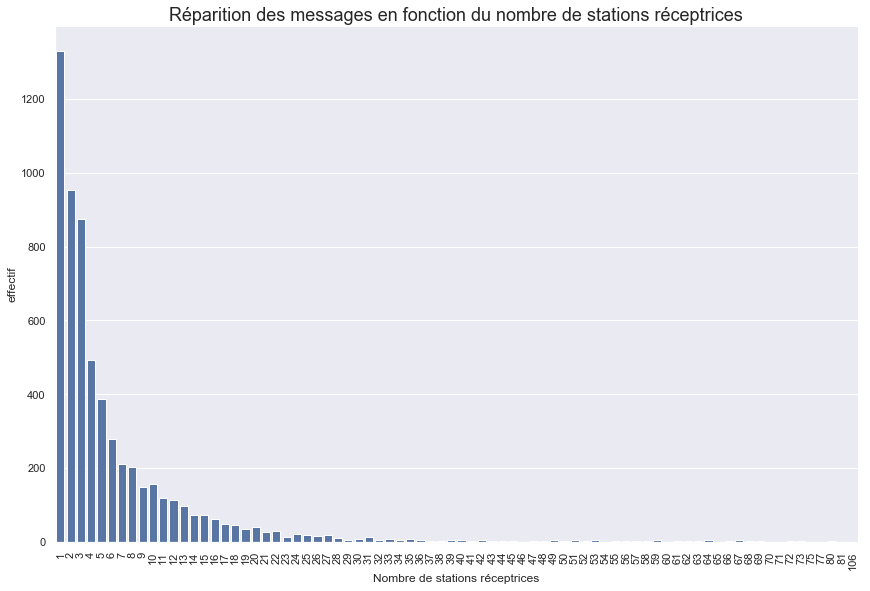

In [11]:
g = sns.catplot(x="nb_stations", height=8,  aspect=1.5, kind="count", data=df_feat, color = 'b')
g.set_xticklabels(rotation=90)
plt.title("Réparition des messages en fonction du nombre de stations réceptrices", fontsize=18)
plt.xlabel('Nombre de stations réceptrices')
plt.ylabel('effectif')
plt.show()

* Binnings, veillant à créer des groupes de poids proche, tout en isolant les plus petite valeurs de façon unitaire

In [12]:
df_feat.groupby(['binned_num']).size().reset_index(name='counts').sort_values(ascending=False,by='counts')

binned_num  counts
0          1    1329
5          6    1029
4          5    1002
1          2     953
3          4     880
2          3     875

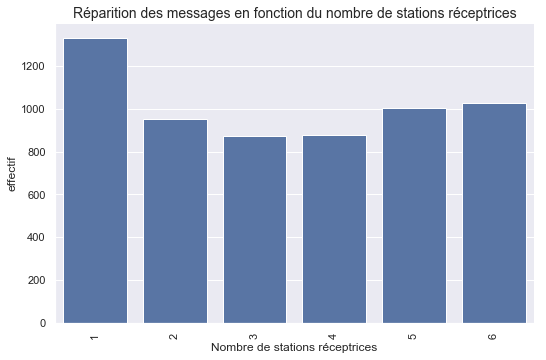

In [13]:
g = sns.catplot(x="binned_num", height=5,  aspect=1.5, kind="count", data=df_feat, color = 'b')
g.set_xticklabels(rotation=90)
plt.title("Réparition des messages en fonction du nombre de stations réceptrices", fontsize=14)
plt.xlabel('Nombre de stations réceptrices')
plt.ylabel('effectif')
plt.show()

#### 4.1.3 -Ajout de la cible aux données d'apprentissage

In [16]:
# Ajout de la cible
df_mess_train[['lat', 'lng']] = pos_train
s_lat = df_mess_train.groupby(['messid']).mean()['lat']
s_lng = df_mess_train.groupby(['messid']).mean()['lng']
df_lat = pd.DataFrame(s_lat)
df_lat = df_lat.reset_index()
df_lng = pd.DataFrame(s_lng)
df_lng = df_lng.reset_index()
df_feat2 = pd.merge(df_feat,df_lat, on='messid')
df_feat2 = pd.merge(df_feat2,df_lng, on='messid')
df_feat2.head()

messid  879_rssi  911_rssi  921_rssi  944_rssi  980_rssi  \
0  573bf1d9864fce1a9af8c5c9    -250.0    -250.0    -250.0    -250.0    -250.0   
1  573bf3533e952e19126b256a    -250.0    -250.0    -250.0    -250.0    -250.0   
2  573c0cd0f0fe6e735a699b93    -250.0    -250.0    -250.0    -250.0    -250.0   
3  573c1272f0fe6e735a6cb8bd    -250.0    -250.0    -250.0    -250.0    -250.0   
4  573c8ea8864fce1a9a5fbf7a    -250.0    -250.0    -250.0    -250.0    -250.0   

   1012_rssi  1086_rssi  1092_rssi  1120_rssi     ...      10148_rssi  \
0     -250.0     -250.0     -250.0     -250.0     ...          -250.0   
1     -250.0     -250.0     -250.0     -250.0     ...          -250.0   
2     -250.0     -250.0     -250.0     -250.0     ...          -250.0   
3     -250.0     -250.0     -250.0     -250.0     ...          -250.0   
4     -250.0     -141.0     -250.0     -250.0     ...          -250.0   

   10151_rssi  10162_rssi  10999_rssi  11007_rssi  11951_rssi  nb_stations  \
0      -250.0      -250.0      -250.0      -250.0      -250.0            2   
1      -250.0      -250.0      -250.0      -250.0      -250.0            1   
2      -250.0      -250.0      -250.0      -250.0      -250.0            3   
3      -250.0      -250.0      -250.0      -250.0      -250.0            4   
4      -250.0      -250.0      -250.0      -250.0      -250.0           42   

   binned_num        lat         lng  
0           2  39.606690 -104.958490  
1           1  39.637741 -104.958554  
2           3  39.730417 -104.968940  
3           4  39.693102 -105.006995  
4           6  39.758167 -105.051016  

[5 rows x 264 columns]

#### 4.1.4 -Echantillonnage

Split 80/20 pour une première approche itérative de construction et d'ajustement des modèles

In [40]:
df_feat_train, df_feat_train_valid = train_test_split(df_feat2,
                                                 train_size=0.8)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
df_feat_train.shape

(4854, 264)

In [19]:
df_feat_train_valid.shape

(1214, 264)

### 4.2 Modélisation

* Réimplemntation du KNN classique 

In [24]:
class KNNRegressorTrad(BaseEstimator, ClassifierMixin):
    """ Homemade kNN classifier class """
    # Constructeur
    def __init__(self, n_neighbors=1):
        self.k=n_neighbors
    # Fit : pas de train  
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self
    # Calcul des distances, ranking, et sélection
    def predict(self, X,r=None):
        distances = pairwise_distances(X,self.X_train,metric='minkowski', n_jobs=-1,p=5)
        ix = np.argsort(distances,axis=1)
        neighbours_sel_indices = ix[:,0:self.k]
        neighbours_sel = self.y_train[neighbours_sel_indices]
        return(np.mean(neighbours_sel,axis=1))

* Adaptation du KNN classique avec nombre de voisin s'ajustant en fonction du nombre de bs réceptrices

In [25]:
class KNNRegressorAdaptative(BaseEstimator, ClassifierMixin):
    """ Homemade kNN classifier class with adaptive k neabourghs"""
    # Constructeur
    def __init__(self, n_neighbors=1):
        self.k=n_neighbors
    # Fit : pas de train  
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self
    # Calcul des distances, rankiong, et sélection
    def predict(self, X, z):
        tab = np.ones((X.shape[0],self.k))
        for i in range(X.shape[0]):
            nk=z[i]
            if nk ==1: nk=3
            if nk ==2: nk=4
            if nk ==3: nk=5
            if nk ==4: nk=6
            if nk ==5: nk=6
            if nk ==6: nk=self.k
            for j in range(self.k):
                if j >= nk:
                    tab[i,j]=0
        distances = pairwise_distances(X,self.X_train,metric='minkowski', n_jobs=-1,p=5)
        ix = np.argsort(distances,axis=1)
        neighbours_sel_indices = ix[:,0:self.k]
        neighbours_sel_1 = self.y_train[neighbours_sel_indices]
        neighbours_sel_2_lat = np.sum((neighbours_sel_1[:,:,0] * tab),axis=1) / tab.sum(axis=1)
        neighbours_sel_2_lng = np.sum((neighbours_sel_1[:,:,1] * tab),axis=1) / tab.sum(axis=1)
        return neighbours_sel_2_lat,neighbours_sel_2_lng

In [35]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    y_pred_lat[np.where(y_pred_lat>90)[0]]=90
    y_pred_lat[np.where(y_pred_lat<-90)[0]]=-90
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    return err_vec

In [27]:
knn_reg = KNNRegressorAdaptative(7)

In [28]:
cols_features = np.arange(1,260)

In [29]:
knn_reg.fit(df_feat_train.iloc[:,cols_features].values, 
            df_feat_train.iloc[:,-2:].values)

KNNRegressorAdaptative(n_neighbors=None)

In [76]:
y_pred_train = knn_reg.predict(df_feat_train.iloc[:,cols_features].values,
                              df_feat_train.iloc[:,-3:-2].values.ravel())

In [77]:
y_pred_train_valid = knn_reg.predict(df_feat_train_valid.iloc[:,cols_features].values,
                                     df_feat_train_valid.iloc[:,-3:-2].values.ravel())

In [78]:
err_vec_train = Eval_geoloc(df_feat_train.iloc[:,-2:-1].values.ravel() , 
                            df_feat_train.iloc[:,-1:].values.ravel(), 
                            y_pred_train[0], y_pred_train[1])

In [79]:
err_vec_train_valid = Eval_geoloc(df_feat_train_valid.iloc[:,-2:-1].values.ravel() , 
                            df_feat_train_valid.iloc[:,-1:].values.ravel(), 
                            y_pred_train_valid[0], y_pred_train_valid[1])

In [80]:
print("Erreur à 80 pct sur le Train : %.0fm" % (np.percentile(err_vec_train, 80)))

Erreur à 80 pct sur le Train : 2568m


In [81]:
print("Erreur à 80 pct sur le Test : %.0fm" % (np.percentile(err_vec_train_valid, 80)))

Erreur à 80 pct sur le Test : 3085m


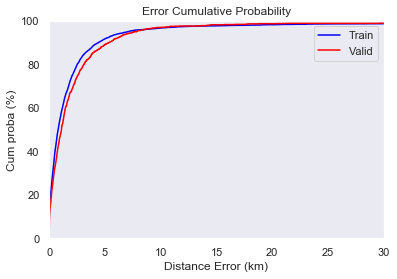

In [48]:
values_train, base_train = np.histogram(err_vec_train, bins=50000)
values, base = np.histogram(err_vec_train_valid, bins=50000)
cumulative_train = np.cumsum(values_train) 
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base_train[:-1]/1000, cumulative_train / np.float(np.sum(values_train))  * 100.0, c='blue')
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='red')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Train", "Valid", "LLR 99"])

### 4.3 Réflexions sur les messages "anormaux"

L'ensemble du process a été réalisé en boucle, avec analyse humaine des anomalies selon le procédé ci-dessous permettant de visualiser des trajectoires présentant des irrégularités.

* Analyse des anomalies à l'issue d'une passe de modélisation (ex sur le set de validation)

In [82]:
df_analyse_ano_valid = df_feat_train_valid.copy()
df_did = pd.DataFrame(df_mess_train.groupby(['messid','did'])["did"].count())
df_did = df_did.drop(columns=["did"])
df_did = df_did.reset_index()
df_analyse_ano_valid["dist"] = err_vec_train_valid
df_analyse_ano_valid = df_analyse_ano_valid.merge(df_did,how='inner',on='messid')
df_analyse_ano_valid.groupby("binned_num")["dist"].agg(['count','mean','std','max','sum'])

count         mean           std            max           sum
binned_num                                                               
1             280  7904.147590  37147.967322  514148.642053  2.213161e+06
2             193  2924.516357  15811.702866  216666.501591  5.644317e+05
3             167  1530.918834   2875.240306   21683.019070  2.556634e+05
4             156  1322.607116   1794.587515   12042.952111  2.063267e+05
5             225   955.276263   1244.348555    8908.154639  2.149372e+05
6             193   946.226729   1431.636250   10973.741786  1.826218e+05

In [83]:
df_analyse_ano_valid.sort_values(by="dist",ascending=False).head()

messid  879_rssi  911_rssi  921_rssi  944_rssi  \
516  57849df012f143318207f0b7    -250.0    -250.0    -250.0    -250.0   
914  582ec2d812f1434b9cacc01f    -250.0    -250.0    -250.0    -250.0   
317  5822e1b212f1434b9c16410d    -250.0    -250.0    -250.0    -250.0   
207  57b6ee1712f14345919c294e    -250.0    -250.0    -250.0    -250.0   
794  57777de312f1433182c5efa3    -250.0    -250.0    -250.0    -250.0   

     980_rssi  1012_rssi  1086_rssi  1092_rssi  1120_rssi    ...     \
516    -250.0     -250.0     -250.0     -250.0     -250.0    ...      
914    -250.0     -250.0     -250.0     -250.0     -250.0    ...      
317    -250.0     -250.0     -250.0     -250.0     -250.0    ...      
207    -250.0     -250.0     -250.0     -250.0     -250.0    ...      
794    -250.0     -250.0     -250.0     -250.0     -250.0    ...      

     10162_rssi  10999_rssi  11007_rssi  11951_rssi  nb_stations  binned_num  \
516      -250.0      -250.0      -250.0      -250.0            1           1   
914      -250.0      -250.0      -250.0      -250.0            1           1   
317      -250.0      -250.0      -250.0      -250.0            2           2   
207      -250.0      -250.0      -250.0      -250.0            1           1   
794      -250.0      -250.0      -250.0      -250.0            1           1   

           lat         lng           dist       did  
516  35.770683 -102.094289  514148.642053  476212.0  
914  37.801703 -103.655277  286845.119427  474192.0  
317  42.398650 -107.066221  216666.501591  474192.0  
207  41.881199 -106.633858  138540.030933  476610.0  
794  39.742911 -105.054798   74597.467784  474176.0  

[5 rows x 266 columns]

* Exemple de suivi d'une device avec outlier

In [57]:
df_msg_ano = df_mess_train.copy()
df_msg_ano[['lat', 'lng']] = pos_train
df_ano = df_msg_ano[df_msg_ano["did"]==474192].groupby(["messid","time_ux","lat","lng"]).count().sort_values(by="time_ux")

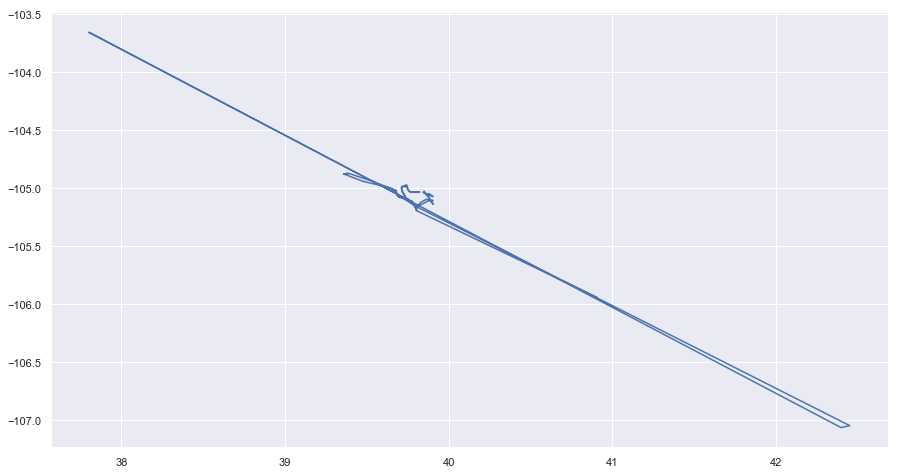

In [84]:
df_ano=df_ano.reset_index()
x = df_ano["lat"].values
y = df_ano["lng"].values
fig = plt.figure(figsize=(15,8))
ax = plt.axes()
ax.plot(x, y)

### 4.4 Cross Validation

Application d'une cross validation plus poussée pour valider les paramétrages et évaluer les performances en généralisation

In [64]:
knn_reg = KNNRegressorAdaptative(7)
kf = KFold(n_splits=100,shuffle=True,random_state=42)

In [65]:
i=1
res = {}
for train_index, test_index in kf.split(df_feat2):
    print("Fold : %d" %(i))
    X_train, X_test = df_feat2.iloc[:,cols_features].values[train_index], df_feat2.iloc[:,cols_features].values[test_index]
    z_train, z_test = df_feat2.iloc[:,-3:-2].values.ravel()[train_index], df_feat2.iloc[:,-3:-2].values.ravel()[test_index]
    y_train, y_test = df_feat2.iloc[:,-2:].values[train_index], df_feat2.iloc[:,-2:].values[test_index]
    knn_reg.fit(X_train, y_train)
    y_pred_train = knn_reg.predict(X_train,z_train)
    y_pred_train_test = knn_reg.predict(X_test,z_test)
    err_vec_train = Eval_geoloc(y_train[:,0].ravel(),  
                            y_train[:,1].ravel(), 
                            y_pred_train[0], y_pred_train[1])
    err_vec_test = Eval_geoloc(y_test[:,0].ravel(), 
                            y_test[:,1].ravel(), 
                            y_pred_train_test[0], y_pred_train_test[1])
    print(np.percentile(err_vec_test, 80))
    res[i] = [np.percentile(err_vec_train, 80),np.percentile(err_vec_test, 80)]
    i+=1

Fold : 1
2531.8911595854315
Fold : 2
2400.5121257339456
Fold : 3
2721.559749279786
Fold : 4
2580.2054191863
Fold : 5
4134.799316547177
Fold : 6
1716.5951241361554
Fold : 7
3317.298397554293
Fold : 8
4196.435023119496
Fold : 9
2184.7611817778916
Fold : 10
2756.9305219952375
Fold : 11
3425.4824708330366
Fold : 12
2336.232042173186
Fold : 13
2712.265486113978
Fold : 14
2692.773676510042
Fold : 15
3533.3830944716938
Fold : 16
4040.032047393825
Fold : 17
2793.843015439266
Fold : 18
3894.4541152686156
Fold : 19
2623.3228858490256
Fold : 20
2789.5273215221723
Fold : 21
2380.4498334656014
Fold : 22
2590.0361338525668
Fold : 23
4108.301485738253
Fold : 24
3605.3426420098017
Fold : 25
4067.533258834392
Fold : 26
3823.7604291548305
Fold : 27
2810.8970543022733
Fold : 28
3200.0349148959754
Fold : 29
2891.7512338513247
Fold : 30
3673.181110835719
Fold : 31
2029.5646328426158
Fold : 32
2413.683782363767
Fold : 33
3318.2552465824833
Fold : 34
2310.3289927826213
Fold : 35
2950.991450149171
Fold : 36
2

In [69]:
df_res = pd.DataFrame(res).T
df_res.rename({0: "Train", 1: "Test"}, axis='columns',inplace=True)
print("Moyenne des résultats obtenus sur une cross-validation à 100 folds : ")
df_res.mean(axis=0)

Moyenne des résultats obtenus sur une cross-validation à 100 folds : 


Train    2493.664727
Test     2878.600038
dtype: float64

L'erreur prédiction sur le test , obtenu après la cross-validation est 2.8 Km . Cette approche nous donne donc le meilleur score et on l'utilisera pour la prédiction finale

## 5. Scoring du jeu de test 

Scoring réalisé à partir du modèle des KNN "adaptatifs", bâti sur la base complète d'apprentissage

In [70]:
################# modèle sur touts le jeux de données ######################
knn_reg_gen = KNNRegressorAdaptative(n_neighbors=7)
knn_reg_gen.fit(df_feat2.iloc[:,cols_features].values, 
            df_feat2.iloc[:,-2:].values)
df_feat_test = feat_mat_const_new(df_mess_test, listOfBs)
df_feat_test.head()

messid  879_rssi  911_rssi  921_rssi  944_rssi  980_rssi  \
0  573be2503e952e191262c351    -250.0    -250.0    -250.0    -250.0    -250.0   
1  573c05f83e952e1912758013    -250.0    -250.0    -250.0    -250.0    -250.0   
2  573c0796f0fe6e735a66deb3    -250.0    -250.0    -250.0    -250.0    -250.0   
3  573c08d2864fce1a9a0563bc    -250.0    -250.0    -250.0    -250.0    -250.0   
4  573c08ff864fce1a9a0579b0    -250.0    -250.0    -250.0    -250.0    -250.0   

   1012_rssi  1086_rssi  1092_rssi  1120_rssi     ...      9949_rssi  \
0     -250.0     -250.0     -250.0     -250.0     ...         -250.0   
1     -250.0     -250.0     -250.0     -250.0     ...         -250.0   
2     -250.0     -250.0     -250.0     -250.0     ...         -250.0   
3     -250.0     -250.0     -250.0     -250.0     ...         -250.0   
4     -250.0     -250.0     -250.0     -250.0     ...         -250.0   

   10134_rssi  10148_rssi  10151_rssi  10162_rssi  10999_rssi  11007_rssi  \
0      -250.0      -250.0      -250.0      -250.0      -250.0      -250.0   
1      -250.0      -250.0      -250.0      -250.0      -250.0      -250.0   
2      -250.0      -250.0      -250.0      -250.0      -250.0      -250.0   
3      -250.0      -250.0      -250.0      -250.0      -250.0      -250.0   
4      -250.0      -250.0      -250.0      -250.0      -250.0      -250.0   

   11951_rssi  nb_stations  binned_num  
0      -250.0            1           1  
1      -250.0            8           5  
2      -250.0            4           4  
3      -250.0            1           1  
4      -250.0            4           4  

[5 rows x 262 columns]

In [71]:
################# prédiction ##################################################
y_pred_lat, y_pred_lng = knn_reg_gen.predict(df_feat_test.values[:,cols_features],df_feat_test.values[:,-1])

In [72]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = df_feat_test["messid"]

In [73]:
test_res.head()

lat         lng                    messid
0  39.723820 -105.062955  573be2503e952e191262c351
1  39.776755 -105.076946  573c05f83e952e1912758013
2  39.679813 -105.014252  573c0796f0fe6e735a66deb3
3  39.784301 -105.070033  573c08d2864fce1a9a0563bc
4  39.679813 -105.014252  573c08ff864fce1a9a0579b0

In [74]:
############### export des résultats ################
test_res.to_csv('pred_pos_test_list.csv', index=False)